# I.12 Estimating gene frequencies

## Normal approximation, exact confidence intervals

Example from the text:

In [1]:
n <- 100 # copies at a locus
nA <- 96

In [2]:
p_hat <- nA / n

In [3]:
# normal approximation
variance <- p_hat * (1 - p_hat) / (2 * n)

p_hat + c(-1.96, 1.96) * sqrt(variance)

[1] 0.9328414 0.9871586

In [4]:
binom.test(nA, n, p_hat)


	Exact binomial test

data:  nA and n
number of successes = 96, number of trials = 100, p-value = 1
alternative hypothesis: true probability of success is not equal to 0.96
95 percent confidence interval:
 0.9007428 0.9889955
sample estimates:
probability of success 
                  0.96 


Also from [here](http://www.stat.yale.edu/Courses/1997-98/101/binom.htm):

_If we know that the count X of "successes" in a group of n observations with sucess probability p has a binomial distribution with mean np and variance np(1-p), then we are able to derive information about the distribution of the sample proportion, the count of successes X divided by the number of observations n. By the multiplicative properties of the mean, the mean of the distribution of X/n is equal to the mean of X divided by n, or np/n = p. This proves that the sample proportion  is an unbiased estimator of the population proportion p. The variance of X/n is equal to the variance of X divided by n², or (np(1-p))/n² = (p(1-p))/n . This formula indicates that as the size of the sample increases, the variance decreases._

Var[2nX] = Var[X]/4n^2 = 2np(1-p)/4n^2 = p(1-p)/2n

## Implementation of the ABO application of the EM-algorithm

Check out the write up [here](http://www.mi.fu-berlin.de/wiki/pub/ABI/Genomics12/Genomics-Exercise-8.pdf) in addition to Felsenstein's chapter.

In [5]:
ABOexpect <- function(na, nb, fa, fb, fo) {
    naa <- na * fa^2 / (fa^2 + 2*fa*fo)
    nao <- na * 2*fa*fo / (fa^2 + 2*fa*fo)

    nbb <- nb * fb^2 / (fb^2 + 2*fb*fo)
    nbo <- nb * 2*fb*fo / (fb^2 + 2*fb*fo)

    list(naa = naa, nao = nao, nbb = nbb, nbo = nbo)
}

ABOmaximize <- function(naa, nao, nbb, nbo, nab, no) {
    n <- naa + nao + nbb + nbo + nab + no

    fa <- (2*naa + nao + nab) / (2*n)
    fb <- (2*nbb + nbo + nab) / (2*n)
    fo <- 1 - fa - fb

    list(fa = fa, fb = fb, fo = fo)
}

In [6]:
ABO_EM <- function(obs_a, obs_b, obs_ab, obs_o) {
    #initial guess
    fa <- 0.05
    fb <- 0.2
    fo <- 1 - fa - fb

    # set up iteration
    iter <- 1
    diff <- 1
    tol <- 0.0001 # tolerance

    while (diff > tol) {
        E <- ABOexpect(obs_a, obs_b, fa, fb, fo)
        M <- ABOmaximize(E$naa, E$nao, E$nbb, E$nbo, obs_ab, obs_o)

        cat(sprintf("iter:%d\n",iter))
        cat("\tassumed allele frequencies: ", c(fa, fb, fo), "\n")
        cat("\texpected genotype counts: ", unlist(E), "\n")
        cat("\tmaximixed allele frequencies: ", unlist(M), "\n")

        diff <- abs(M$fa - fa) + abs(M$fb - fb) + abs(M$fo - fo)
        fa <- M$fa
        fb <- M$fb
        fo <- M$fo

        cat(sprintf("\tdiff:%.10f\n", diff))

        iter <- iter + 1
    }

    cat(sprintf("f_a=%.4f, f_b=%.4f, f_o=%.4f\n", fa, fb, fo))
    
    invisible(list(a = fa, b = fb, o = fo))
}

In [7]:
# what we don't know (hidden truth - the real frequencies)
fa <- 0.15
fb <- 0.6
fo <- 1 - fa - fb

n <- 1000

naa <- n * fa^2
nbb <- n * fb^2
nao <- n * 2*fa*fo
nbo <- n * 2*fb*fo
nab <- n * 2*fa*fb
noo <- n * fo^2

# what we /actually/ observe
obs_a <- naa + nao
obs_b <- nbb + nbo
obs_ab <- nab
obs_o <- noo

In [8]:
# these have to sum to `n' unless I made a typo

# phenotype counts
obs_a + obs_b + obs_ab + obs_o
# genotype counts
naa + nbb + nao + nbo + nab + noo

[1] 1000

[1] 1000

Trivial test: do one round of E and M, feeding the former into the latter step (using the true frequencies as an initial "guess"):

In [9]:
E <- ABOexpect(obs_a, obs_b, fa, fb, fo)
E

$naa
[1] 22.5

$nao
[1] 75

$nbb
[1] 360

$nbo
[1] 300

In [10]:
m <- ABOmaximize(E$naa, E$nao, E$nbb, E$nbo, obs_ab, obs_o)
m

$fa
[1] 0.15

$fb
[1] 0.6

$fo
[1] 0.25

Run full EM:

In [11]:
ABO_EM(obs_a, obs_b, obs_ab, obs_o)

iter:1
	assumed allele frequencies:  0.05 0.2 0.75 
	expected genotype counts:  3.145161 94.35484 77.64706 582.3529 
	maximixed allele frequencies:  0.1403226 0.4588235 0.4008539 
	diff:0.6982922201
iter:2
	assumed allele frequencies:  0.1403226 0.4588235 0.4008539 
	expected genotype counts:  14.52337 82.97663 240.2348 419.7652 
	maximixed allele frequencies:  0.1460117 0.5401174 0.3138709 
	diff:0.1739659794
iter:3
	assumed allele frequencies:  0.1460117 0.5401174 0.3138709 
	expected genotype counts:  18.3988 79.1012 305.2401 354.7599 
	maximixed allele frequencies:  0.1479494 0.5726201 0.2794305 
	diff:0.0688807314
iter:4
	assumed allele frequencies:  0.1479494 0.5726201 0.2794305 
	expected genotype counts:  20.40868 77.09132 334.0129 325.9871 
	maximixed allele frequencies:  0.1489543 0.5870064 0.2640392 
	diff:0.0307825998
iter:5
	assumed allele frequencies:  0.1489543 0.5870064 0.2640392 
	expected genotype counts:  21.45103 76.04897 347.4392 312.5608 
	maximixed allele frequen

# I.13 Testing hypotheses about frequencies

## $\chi^2$ test

In [12]:
# calculate 95% significance level for chi-square distribution with 1 degree of freedom
# this is a one-tailed test because we're testing for a statistic value at least as
# large as what we observed
qchisq(0.95, df = 1, lower.tail = T)

[1] 3.841459

Example from the text:

In [13]:
nobserved <- c(520, 426, 54)
nexpected <- c(537.29, 391.42, 71.29)

sum((nobserved - nexpected)^2/nexpected)

[1] 7.804715

### Likelihood-ratio test

Is a likelihood of an alternative hypothesis (what Felsenstein calls "hypothesis of no constraint") higher than the likelihood of the null hypothesis (hypothesis constrained by Hardy-Weinberg proportions)?

To do this, we calculate $2 \times ln(\frac{L_1}{L_0})$ which has approximately a $\chi^2$ distribution, with degrees of freedom equal to the difference between the number of parameters under the alternative and null hypotheses.

G-statistic: $G = 2 \times ln(\frac{L_1}{L_0}) = -2\sum_i{n_i \times ln \frac{n_i}{N_i}}$

In [14]:
-2 * sum(nobserved * log(nobserved / nexpected))

[1] -8.111862

Example from [here](http://www.biostathandbook.com/gtestgof.html):

In [15]:
n_obs <- 770
n <- 1000
p <- n_obs / n

In [16]:
# null
dbinom(n_obs, n, 3/4)

[1] 0.0101099

In [17]:
# alt
dbinom(n_obs, n, p)

[1] 0.02996627

# Exercises

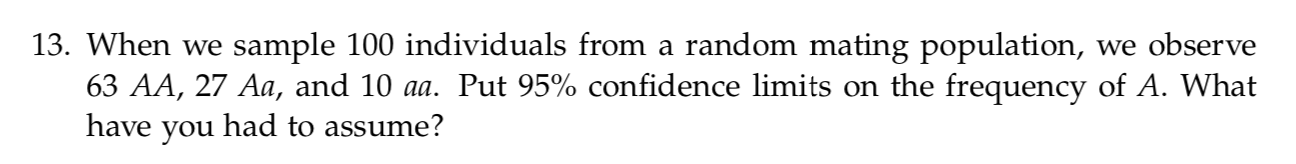

In [108]:
n <- 100

nAA <- 63
nAa <- 27
naa <- 10

Assuming Hardy-Weinberg we can calculate the expected frequency of _A_:

In [114]:
(pA <- (2*nAA + nAa) / (2*n))

[1] 0.765

In [118]:
sqrt(nAA / n)

[1] 0.7937254

In [115]:
# normal approximation of 95% CI
# This approximation is based on the central limit theorem and
# is unreliable when the sample size is small or the probability
# is close to 0 or 1.
variance <- pA * (1 - pA) / (2 * n)
pA + c(-1.96, 1.96) * sqrt(variance)

[1] 0.7062368 0.8237632

This should be the almost same as simulating the confidence intervals and taking the central 95% of the simulated distribution:

In [21]:
p_sim <- replicate(100000, mean(rbinom(2 * n, 1, pA)))
quantile(p_sim, probs = c(0.025, 0.975))

2.5% 97.5% 
0.705 0.820

In [117]:
# exact binomial solution
binom.test(pA * 2*n, 2*n, pA)


	Exact binomial test

data:  pA * 2 * n and 2 * n
number of successes = 153, number of trials = 200, p-value = 1
alternative hypothesis: true probability of success is not equal to 0.765
95 percent confidence interval:
 0.7000381 0.8219293
sample estimates:
probability of success 
                 0.765 


In [23]:
.Last.value$conf.int

[1] 0.7000381 0.8219293
attr(,"conf.level")
[1] 0.95

Also known as [Clopper-Pearson confidence interval](https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval#Clopper%E2%80%93Pearson_interval).

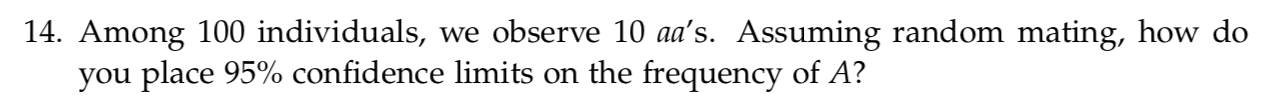

In [120]:
n <- 100

naa <- 10

In [121]:
(pa <- sqrt(naa / 100)) # freq of the 'a' can be expressed as sqrt(proportion of 'aa' homozygotes)

[1] 0.3162278

In [122]:
(pA <- 1 - pa)

[1] 0.6837722

In [123]:
# normal approximation of 95% CI
variance <- pA * (1 - pA) / (2 * n)
pA + c(-1.96, 1.96) * sqrt(variance)

[1] 0.6193261 0.7482184

In [124]:
# exact binomial solution
binom.test(as.integer(pA * 2*n), 2*n, pA)$conf.int

[1] 0.6105301 0.7440388
attr(,"conf.level")
[1] 0.95

_"R. A. Fisher showed that maximum likelihood estimates make more efficient use of data than do others."_

Get a CI on aa in a first step.

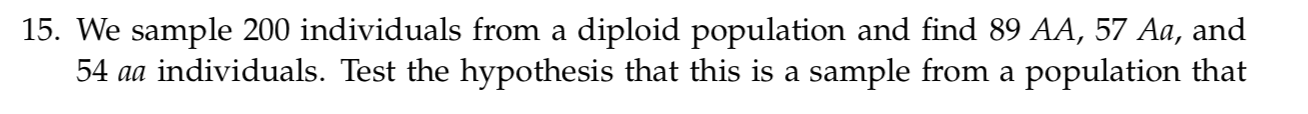
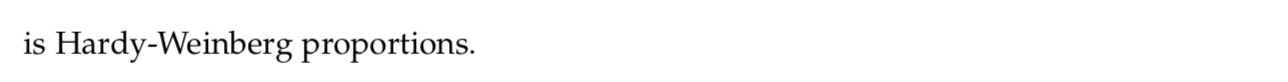

In [69]:
n <- 200

obsAA <- 89
obsAa <- 57
obsaa <- 54

Calculate maximum likelihood of _A_ frequency:

In [70]:
(pA <- (2*obsAA + obsAa) / (2*n))

[1] 0.5875

In [71]:
# HW gives us a model for generating expected genotype proportions given assumed allele frequencies
expAA <- n * pA^2
expAa <- n * 2*pA*(1-pA)
expaa <- n * (1-pA)^2

In [72]:
nobs <- c(obsAA, obsAa, obsaa)
nexp <- c(expAA, expAa, expaa)

In [73]:
nobs
nexp

[1] 89 57 54

[1] 69.03125 96.93750 34.03125

In [74]:
(chisq_val <- sum((nobs - nexp)^2 / nexp))

[1] 33.94752

What's the critical value of the $\chi^2$ we use for the test?

In [75]:
# degrees of freedom = k - 1 - m
#   where k is the number of classes (of the multinomial) and
#   m is the number of independent allele frequencies estimated
qchisq(0.95, df = 3 - 1 - 1, lower.tail = T)

[1] 3.841459

In [76]:
pchisq(chisq_val, df = 1, lower.tail = F)

[1] 5.661866e-09

<br>
What if the population is in HWE?

In [61]:
n <- 200

obsAA <- 55
obsAa <- 103
obsaa <- 42

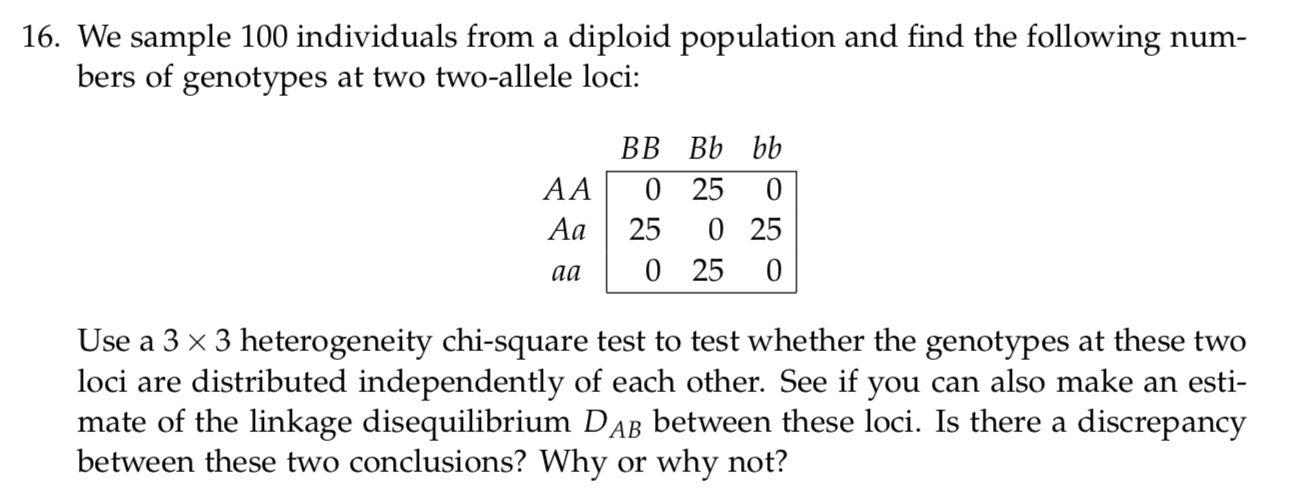

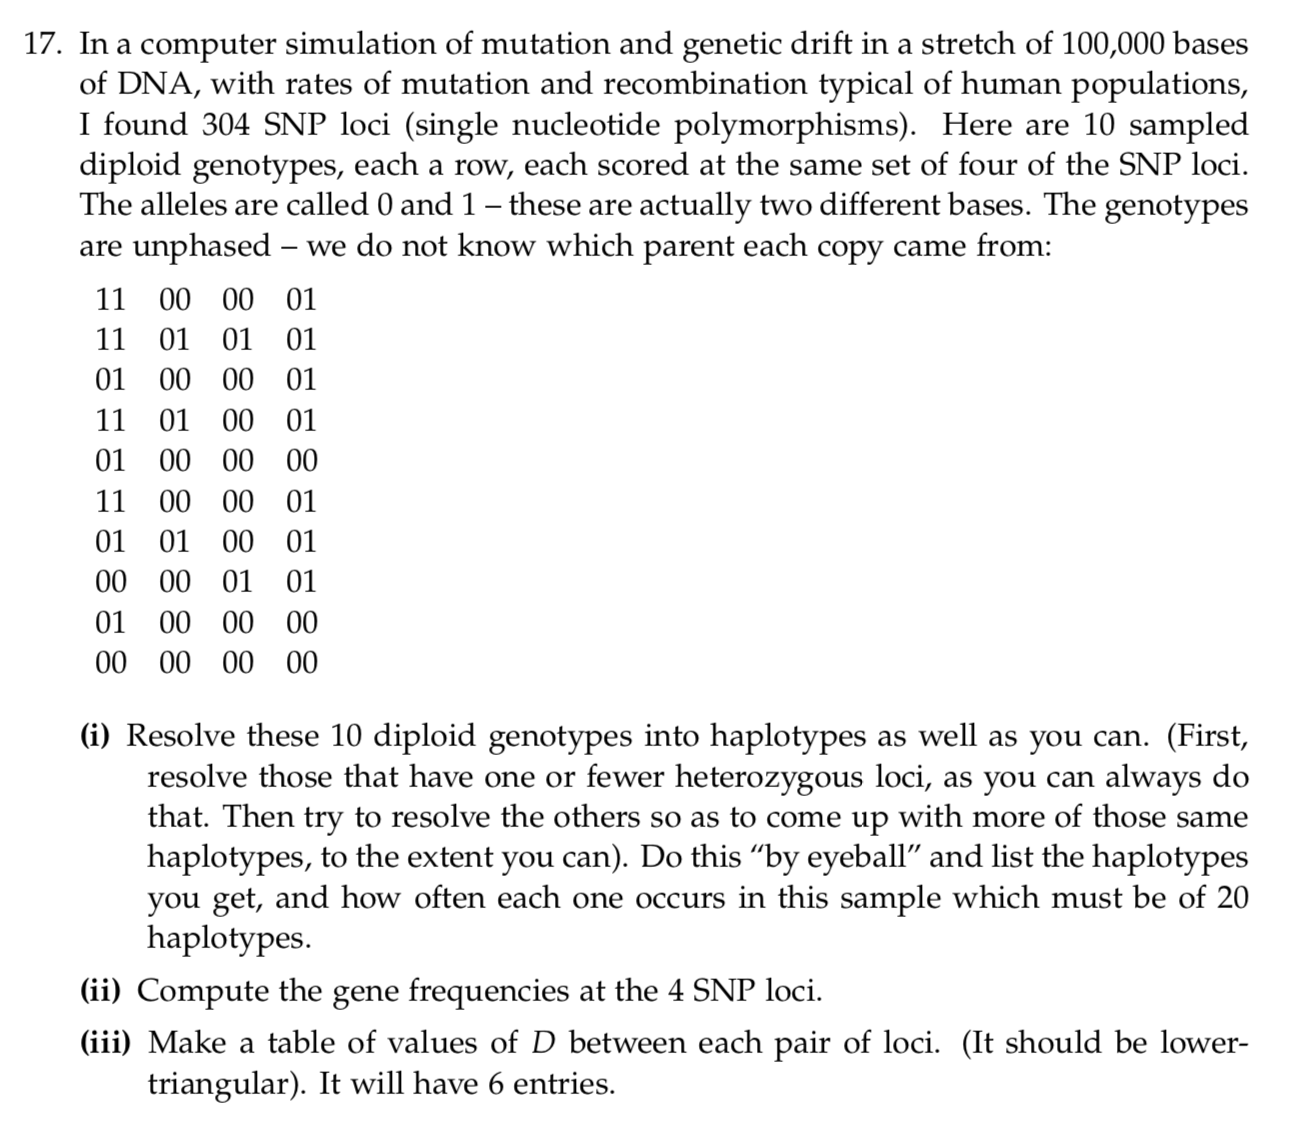
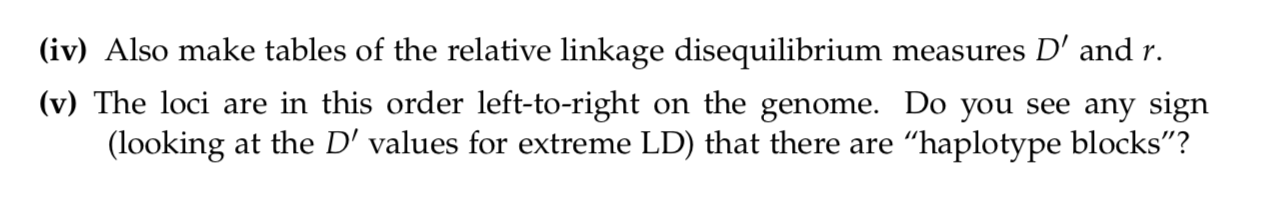

## Complements/Problems

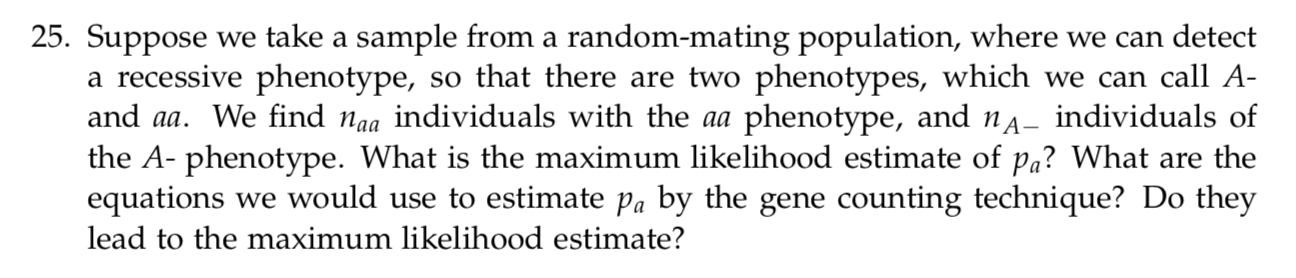

Problem:
- We have the count of A- phenotype individuals (`nA_`) and the count of the aa recessive phenotype (`naa`).
- We don't know what proportion of the A- phenotype individuals is of genotype Aa and what is AA.

EM solution:


- (expectation) Assuming we know `pA` and `pa` allele frequencies we can calculate (based on HWE) the _expected_ counts of individual genotypes:

$$n_{AA} = n_{A-} \times \frac{p_A^2}{p_A^2 + 2p_Ap_a}$$
$$n_{Aa} = n_{A-} \times \frac{2p_Ap_a}{p_A^2 + 2p_Ap_a}$$

- (maximization) On the other hand, assuming we do know the counts of individual genotypes `nAA`, `nAa` and `naa`, we can calculate the frequences of the _a_ and _A_ alleles, `pa` and `pA` as

$$p_A = \frac{2n_{AA} + n_{Aa}}{2n}$$
$$p_a = 1 - p_A$$

Expectation and maximization functions:

In [125]:
expectation <- function(nA_, naa, pA, pa) {
    nAA <- nA_ * pA^2 / (pA^2 + 2*pA*pa)
    nAa <- nA_ * 2*pA*pa / (pA^2 + 2*pA*pa)
    naa <- naa

    list(nAA = nAA, nAa = nAa, naa = naa)
}

In [128]:
maximization <- function(nAA, nAa, naa) {
    n <- nAA + nAa + naa

    pa <- (2*naa + nAa) / (2*n)
    pA <- 1 - pa

    list(pA = pA, pa = pa)
}

Sanity checks:

In [129]:
# assuming the true (but unknown) frequencies are 0.2 (A) and 0.8 (a)
x <- 0.2
y <- 0.8
# and our population sample is 200
N <- 200

In [130]:
expectation(
    nA_ = N * (x^2 + 2*x*y),
    naa = N * y^2,
    pA = x,
    pa = y
)

$nAA
[1] 8

$nAa
[1] 64

$naa
[1] 128

In [131]:
N * x^2
N * 2*x*y
N * y^2

[1] 8

[1] 64

[1] 128

In [132]:
maximization(
    nAA = N * x^2,
    nAa = N * 2*x*y,
    naa = N * y^2
)

$pA
[1] 0.2

$pa
[1] 0.8

### EM algorithm

Let's assume we sampled 300 individuals from the population of interest:

In [133]:
N <- 300

Let's say our the true (unknown) values of _A_ and _a_ frequencies are:

In [134]:
(x <- 0.9)
(y <- 1 - x)

[1] 0.9

[1] 0.1

This means that the true (yet hidden) genotype counts (_AA_, _Aa_, _aa_, in order) are:

In [136]:
N * x^2
N * 2*x*y
N * y^2

[1] 243

[1] 54

[1] 3

Therefore, assuming HWE, the observed phenotype counts (and the _only thing_ we can observe) are:

In [137]:
(A_ <- N * (x^2 + 2*x*y))
(aa <- N * (1-x)^2)

[1] 297

[1] 3

In [138]:
# initial guess of genotype frequencies - let's start somewhere REALLY far from truth
pA <- 0.01
pa <- 1 - pA

# EM iteration
iter <- 1
diff <- 1
tol <- 0.00001

while (diff > tol) {
    E <- expectation(
        nA_ = A_,
        naa = aa,
        pA = pA,
        pa = pa
    )
    M <- maximization(E$nAA, E$nAa, E$naa)

    cat(sprintf("iter:%d\n",iter))
    cat("\tassumed allele frequencies: ", c(pA, pa), "\n")
    cat("\texpected genotype counts: ", unlist(E), "\n")
    cat("\tmaximixed allele frequencies: ", unlist(M), "\n")

    diff <- abs(M$pA - pA) + abs(M$pa - pa)

    cat(sprintf("\tdiff:%.10f\n\n", diff))

    pA <- M$pA
    pa <- M$pa

    iter <- iter + 1
}

cat("-----------------------------------------------------------\n")
cat(sprintf("\nfrequency of 'A' = %.4f, frequency of 'a' = %.4f\n", pA, pa))

iter:1
	assumed allele frequencies:  0.01 0.99 
	expected genotype counts:  1.492462 295.5075 3 
	maximixed allele frequencies:  0.4974874 0.5025126 
	diff:0.9749748744

iter:2
	assumed allele frequencies:  0.4974874 0.5025126 
	expected genotype counts:  98.33779 198.6622 3 
	maximixed allele frequencies:  0.6588963 0.3411037 
	diff:0.3228177678

iter:3
	assumed allele frequencies:  0.6588963 0.3411037 
	expected genotype counts:  145.9188 151.0812 3 
	maximixed allele frequencies:  0.738198 0.261802 
	diff:0.1586032780

iter:4
	assumed allele frequencies:  0.738198 0.261802 
	expected genotype counts:  173.7553 123.2447 3 
	maximixed allele frequencies:  0.7845922 0.2154078 
	diff:0.0927884189

iter:5
	assumed allele frequencies:  0.7845922 0.2154078 
	expected genotype counts:  191.7248 105.2752 3 
	maximixed allele frequencies:  0.8145414 0.1854586 
	diff:0.0598984679

iter:6
	assumed allele frequencies:  0.8145414 0.1854586 
	expected genotype counts:  204.0719 92.92809 3 
	maximi

<br>Our (unknown) true values were:

In [139]:
c(x, y)

[1] 0.9 0.1

<br><br><br>
Of course, in this particular example, because we know what the proportion of the _aa_ phenotype is, assuming HWE we can calculate the frequency of _a_ directly as $\sqrt(\textrm{proportion of the aa phenotype})$:

In [141]:
sqrt(aa/N)

[1] 0.1

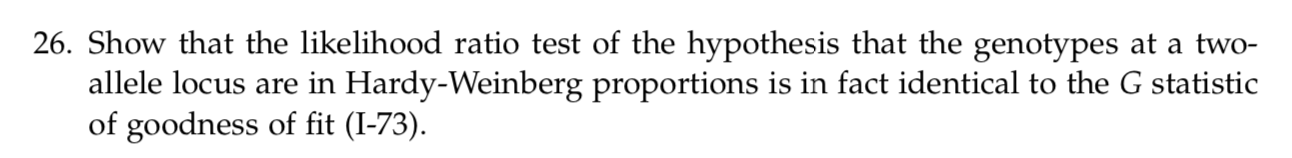

(I-73):<br>
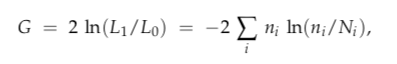

Let's say we observed the following counts of observations among $m$ categories:

$$X = (x_1, x_2, ..., x_m)$$

where

$$\sum_i^M x_i = n.$$

In the case of HWE test, these would be our counts of individuals with AA, Aa or aa genotypes, in which case we would have $X = (x_{AA}, x_{Aa}$ and $x_{aa})$.

Then $X$ follows a multinomial distribution, $X \sim $ Multinomial$(n, p)$ with a total count of $n$ and probabilities of the $m$ categories $p = (p_1, p_2, ..., p_m) = (\frac{x_1}{n}, \frac{x_2}{n}, ..., \frac{x_m}{n})$.

We are interested in testing whether $X$ is consistent with the hypothesis $H_0$.

$$H_0: p = p(\theta),$$
where $\theta$ is some unknown parameter,

as opposed to

$$H_1: p \neq p(\theta).$$

Again, for our HWE example, we would be thinking of $\theta$ as the hidden (true) allele frequency in the population under Hardy-Weinberg equilibrium, testing

$$H_0: p = (\theta^2, 2\theta(1-\theta), (1-\theta)^2)$$

against

$$H_1: \textrm{the locus does not follow HWE}.$$

So we want to compare two models: one which is restricted by HWE (null model) and the other which isn't (alternative model).

Let's call $L_0$ and $L_1$ the likelihoods of both hypotheses and define the likelihood ratio as

$$\lambda = \frac{L_1}{L_0}.$$

From the definition of multinomial distribution we have the following likelihoods:

- likelihood of the null hypothesis:

$$L_0 = \binom{n}{x_1,x_2,...,x_m} p(\theta)^x_1 ... p(\theta)^x_m = \frac{n!}{x_1!.x_2!...x_m!} \prod_i^m p_i(\theta)^{x_i}.$$

- likelihood of the alternative hypothesis:

$$L_1 = \binom{n}{x_1,x_2,...,x_m} p^x_1 ... p^x_m = \frac{n!}{x_1!.x_2!...x_m!} \prod_i^m p_i^{x_i}, \textrm{    where  } p_i = \frac{x_i}{n} \textrm{ (i.e. the observed proportions)}.$$

Plugging in the definitions of $L_0$ and $L_1$ into $\lambda = \frac{L_1}{L_0}$ we see that the multinomial coefficients in the numerator and denominator cancel out, leaving:

$$\lambda = \frac{L_1}{L_0} = \prod_i^m (\frac{p_i}{p_i(\theta)})^{x_i}.$$

Taking the log of this we get

$$log \lambda = log \frac{L_1}{L_0} = log \prod_i^m (\frac{p_i}{p_i(\theta)})^{x_i} = \sum_i^m log (\frac{p_i}{p_i(\theta)})^{x_i}
 = \sum_i^m x_i log (\frac{p_i}{p_i(\theta)}).$$

Continuing from this:

$$\sum_i^m x_i log (\frac{p_i}{p_i(\theta)})
= \sum_i^m x_i log (\frac{n p_i}{n p_i(\theta)})
= \sum_i^m x_i log (\frac{x_i}{x_i^0})$$

We get


$$log \lambda
= log \frac{L_1}{L_0}
= \sum_i^m O_i log (\frac{O_i}{E_i})$$

and

$$2 log \lambda
= 2 log \frac{L_1}{L_0}
= 2 \sum_i^m O_i log (\frac{O_i}{E_i})$$

(O_i - E_i)^2 / E_i

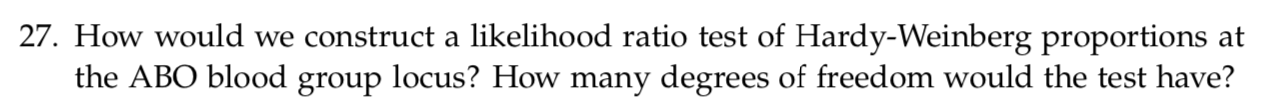

Problem - let's assume we have the A, B, AB, O phenotype counts. In order to test for HWE, we need allele frequencies, because this is what we calculate our expectations for.

We can use the EM algorithm described for the ABO locus above (BTW, also check out [this](http://darwin.eeb.uconn.edu/eeb348-notes/testing-hardy-weinberg.pdf) tutorial which shows Bayesian estimation using JAGS instead of EM).

Let's use these numbers as an example (from the tutorial linked above):

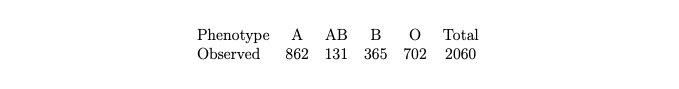

In [142]:
obs_a <- 862
obs_b <- 365
obs_ab <- 131
obs_o <- 702

observed <- c(obs_a, obs_b, obs_ab, obs_o)

(N <- sum(observed))

[1] 2060

In [143]:
f <- ABO_EM(obs_a = 862, obs_b = 365, obs_ab = 131, obs_o = 702)

iter:1
	assumed allele frequencies:  0.05 0.2 0.75 
	expected genotype counts:  27.80645 834.1935 42.94118 322.0588 
	maximixed allele frequencies:  0.2477686 0.130811 0.6214205 
	diff:0.3955371124
iter:2
	assumed allele frequencies:  0.2477686 0.130811 0.6214205 
	expected genotype counts:  143.2813 718.7187 34.75844 330.2416 
	maximixed allele frequencies:  0.2757964 0.1288249 0.5953787 
	diff:0.0560557603
iter:3
	assumed allele frequencies:  0.2757964 0.1288249 0.5953787 
	expected genotype counts:  162.1056 699.8944 35.6333 329.3667 
	maximixed allele frequencies:  0.2803654 0.1290372 0.5905974 
	diff:0.0095626705
iter:4
	assumed allele frequencies:  0.2803654 0.1290372 0.5905974 
	expected genotype counts:  165.3541 696.6459 35.94675 329.0532 
	maximixed allele frequencies:  0.2811539 0.1291133 0.5897328 
	diff:0.0017291322
iter:5
	assumed allele frequencies:  0.2811539 0.1291133 0.5897328 
	expected genotype counts:  165.9259 696.0741 36.01338 328.9866 
	maximixed allele frequenc

In [144]:
f

$a
[1] 0.2813173

$b
[1] 0.1291325

$o
[1] 0.5895502

<br>Using standard HWE equations, calculated the expected genotype proportions given the estimated allele frequencies:

In [146]:
exp_a <- f$a^2 + 2 * f$a * f$o
exp_b <- f$b^2 + 2 * f$b * f$o
exp_ab <- 2 * f$a * f$b
exp_o <- f$o^2

In [147]:
(expected <- N * c(exp_a, exp_b, exp_ab, exp_o))

[1] 846.3320 348.0069 149.6681 715.9930

In [102]:
observed

[1] 862 365 131 702

Calculate $\chi^2$ statistic

In [103]:
(chisq_value <- sum((observed - expected)^2 / expected))

[1] 3.721773

The number of degrees of freedom is:

`[number of classes (4 for each phenotype) - 1] - [number of frequencies (3 for each allele) - 1]`:

In [104]:
(ndegrees <- (4 - 1) - (3 - 1))

[1] 1

And so the critical value of $\chi^2$ is:

In [105]:
qchisq(0.95, df = ndegrees)

[1] 3.841459

In [106]:
1 - pchisq(chisq_value, df = ndegrees)

[1] 0.05370733

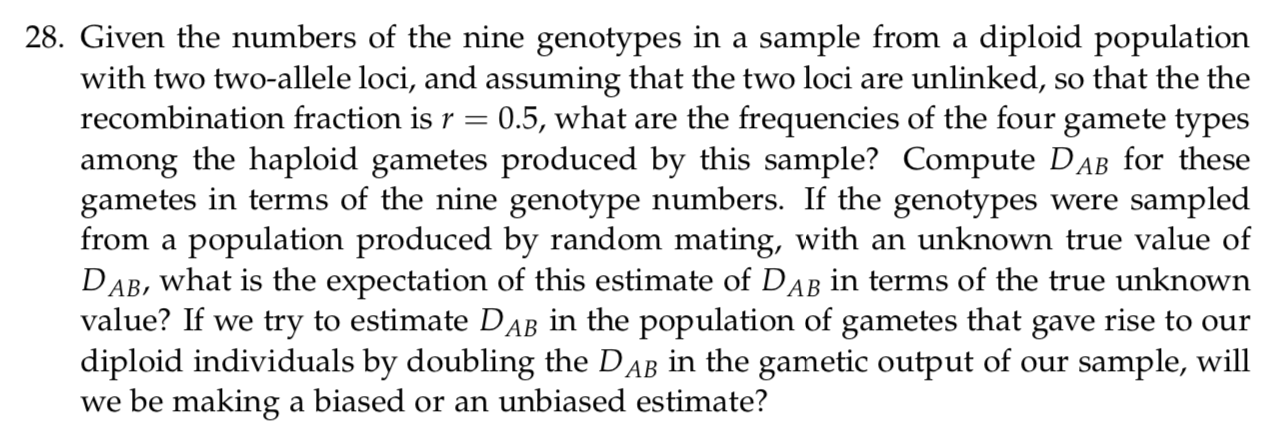